In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.optim as optim



In [2]:
# Chargement des donnes du fichier credit_card_data

df=pd.read_csv("credit_card_data.csv")
df


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


In [3]:
X = df.drop('fraud', axis=1)
y = df['fraud']

In [4]:
#normalisation des donnees numeriques 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Création des ensembles d'entraînement et de test 
X_train = X_scaled[y == 0]
X_test = X_scaled


In [6]:
# conservation en tensor pytorch 
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [7]:
import torch.nn as nn

class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8)
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        w = self.decoder(z)
        return w


justifications des choix 

- Nombre de couches : Nous avons choisi une architecture avec 3 couches dans l’encodeur et 3 couches dans le décodeur, soit 6 couches cachées au total. Cela permet au modèle de capturer la complexité des données tout en gardant une structure symétrique pour la reconstruction.  

- Nombre de neurones par couche :  
  - Dans l’encodeur : 64-32 - 16 - 8 neurones.  
  - Dans le décodeur : 8 - 16 - 32-64 neurones.  
  Ce choix progressif de réduction (64-32 - 16 -8) permet de compresser l’information de manière progressive afin d’apprendre une représentation compacte. Le décodeur reprend ensuite la même logique pour reconstruire les données.  

- Fonction d’activation : Nous avons utilisé ReLU après chaque couche sauf à la sortie. Ce choix s’explique par sa simplicité,sa rapidité de calcul et sa capacité à éviter le problème du gradient qui disparaît, ce qui facilite l’entraînement du réseau.  

- Taille de la couche latente: La dimension latente est à 8 neurones. Cette taille est suffisamment petite pour forcer le modèle à apprendre uniquement les caractéristiques les plus importantes des données normales, ce qui améliore la détection d’anomalies





In [8]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


Recherche d’hyperparamètres

Afin d’améliorer les performances du modèle, nous avons procédé à une recherche des hyperparamètres les plus pertinents.

Hyperparamètres testés

Taux d’apprentissage: nous avons testé plusieurs valeurs (0.01, 0.001, 0.0005).

Résultat : 0.001 était le plus adapté pour notre cas

Batch size : nous avons comparé (32, 64, 128).

Résultat : 128 a offert le meilleur nombre de detection de fraude 
Avec 32 et 64, le modèle trouvais des nombres de detection de fraude bas 

Nombre d’époques : nous avons testé entre 10 et 50.

Résultat : 20 époques ont suffit pour nous donner une bonne precision donc plus de 20 epoques n'etaient pas necessaires et moins de 20 ne nous donnaient pas un resultat de confiance 

Dimension latente : nous avons testé (4, 8, 16).

Résultat : 8 neurones latents offraient le meilleur resultat


Méthode de sélection

Pour chaque configuration, nous avons observé :

La courbe de perte d’entraînement (MSE).

Le taux de détection d’anomalies.

Hyperparamètres retenus

Learning rate : 0.001

Batch size : 64

Époques : 20

Dimension latente : 8

Conclusion

Cette recherche a montré que des hyperparamètres bien choisis permettent d’obtenir une détection efficace des anomalies, et que le batch size de 64 représentait le meilleur choix pour notre modèle.


Entrainement


In [9]:
# définir la dimension d’entrée
input_dim = 7  

# créer le modèle
model = SimpleAutoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_size = 128
epochs = 20

train_loader = torch.utils.data.DataLoader(X_train_tensor, batch_size=batch_size, shuffle=True)

losses = []
for epoch in range(epochs):
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(train_loader))
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {losses[-1]:.6f}")

Epoch [1/20] - Loss: 0.046079
Epoch [2/20] - Loss: 0.008996
Epoch [3/20] - Loss: 0.005334
Epoch [4/20] - Loss: 0.005858
Epoch [5/20] - Loss: 0.004698
Epoch [6/20] - Loss: 0.006284
Epoch [7/20] - Loss: 0.007622
Epoch [8/20] - Loss: 0.004797
Epoch [9/20] - Loss: 0.003820
Epoch [10/20] - Loss: 0.004945
Epoch [11/20] - Loss: 0.004958
Epoch [12/20] - Loss: 0.002508
Epoch [13/20] - Loss: 0.002842
Epoch [14/20] - Loss: 0.007720
Epoch [15/20] - Loss: 0.007341
Epoch [16/20] - Loss: 0.005354
Epoch [17/20] - Loss: 0.006370
Epoch [18/20] - Loss: 0.008844
Epoch [19/20] - Loss: 0.005274
Epoch [20/20] - Loss: 0.016364


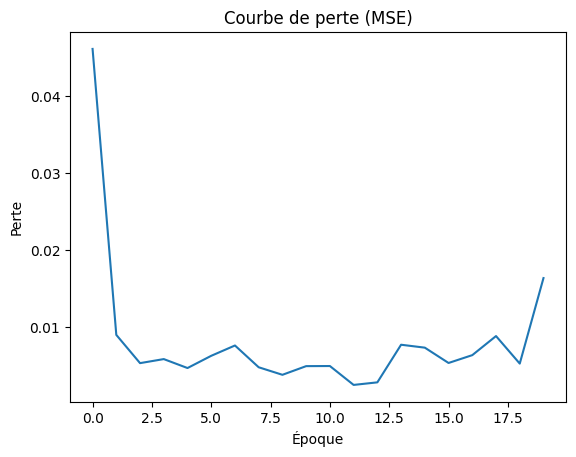

In [11]:
# Courbe de perte
plt.plot(losses)
plt.title("Courbe de perte (MSE)")
plt.xlabel("Époque")
plt.ylabel("Perte")
plt.show()

In [12]:
# Sauvegarde du modèle entraîné
torch.save(model.state_dict(), "modele_final.pt")


In [13]:
# 4. Détection d'anomalies


model.eval()
with torch.no_grad():
    reconstructed = model(X_test_tensor)
    mse = torch.mean((X_test_tensor - reconstructed)**2, dim=1).numpy()

In [14]:
# Seuil basé sur le 95e percentile des erreurs d'entraînement
with torch.no_grad():
    recon_train = model(X_train_tensor)
    mse_train = torch.mean((X_train_tensor - recon_train)**2, dim=1).numpy()
threshold = np.percentile(mse_train, 95)
print("Seuil de détection :", threshold)


Seuil de détection : 0.0012347667


Justification du seuil de detection 

Le seuil de détection a été calculé sur la base du 95ᵉ percentile des erreurs de reconstruction observées sur l’ensemble d’entraînement.  
En pratique, cela signifie que les 5% d’erreurs les plus élevées sont considérées comme des anomalies.  

 Le seuil obtenu était environ :   0.0010456066

In [15]:
# Prédictions
pred_anomaly = (mse > threshold).astype(int)

In [16]:
# Taux de détection sur les vraies fraudes
print("Fraudes détectées :", sum((pred_anomaly==1) & (y==1)))
print("Total fraudes :", sum(y==1))

Fraudes détectées : 76942
Total fraudes : 87403


In [17]:
import shap

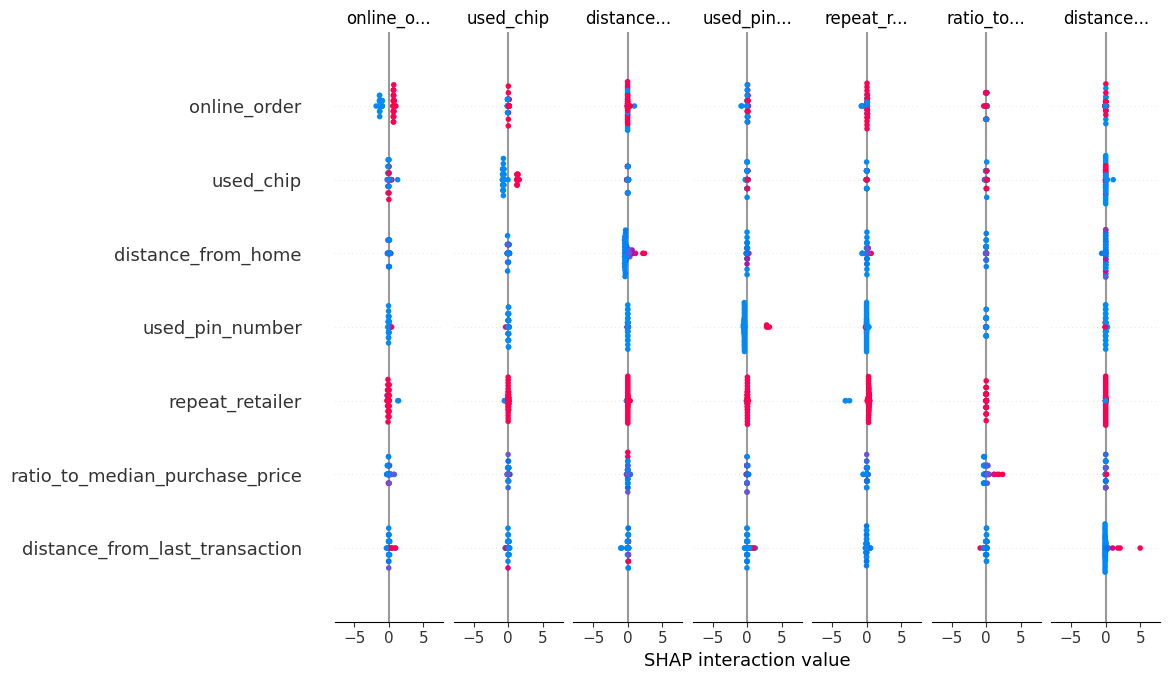

In [18]:
#  Définition des colonnes 
features = [
    "distance_from_home",
    "distance_from_last_transaction",
    "ratio_to_median_purchase_price",
    "repeat_retailer",
    "used_chip",
    "used_pin_number",
    "online_order"
]

# Conversion en DataFrame si nécessaire 
if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train, columns=features)

if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=features)

# Conversion en tenseurs
X_train_torch = torch.tensor(X_train.values, dtype=torch.float32)
X_test_torch  = torch.tensor(X_test.values, dtype=torch.float32)

#  Échantillons pour SHAP 
background   = X_train_torch[:100]
test_samples = X_test_torch[:50]

# Explainer 
explainer = shap.DeepExplainer(model, background)

# Valeurs SHAP 
shap_values = explainer.shap_values(test_samples)
if isinstance(shap_values, list):
    shap_values = shap_values[0]

# Visualisation des résultats
shap.summary_plot(shap_values, test_samples.numpy(), feature_names=features)


Les attributs qui expliquent pourquoi le modele les considere comme inhabituelle sont classés selon le plus influent:


 used_chip, used_pin_number,
 online_order,
 distance_from_home,
 distance_from_last_transaction,
 distance_from_home, distance_from_last_transaction,
 ratio_to_median_purchase_price,

Synthèse 
- Des habitudes de paiement différentes

Le modèle a repéré que le mode de paiement joue un rôle clé.

Les transactions effectuées avec used_chip sont généralement considérées comme normales.

Cependant, l’absence d’utilisation de la puce ou du code PIN peut augmenter la probabilité d’anomalie, car ces transactions sont perçues comme moins sécurisées.

- Les achats en ligne sont plus complexes

Le modèle accorde beaucoup d’importance au fait qu’une transaction soit online_order

Les commandes en ligne, surtout si elles sont inhabituelles pour un client, ressortent comme plus risquées.

- La distance a entrainer aussi un doute

Certaines anomalies sont détectées lorsqu’une transaction est réalisée très loin de la maison ou loin de la dernière transaction.

Par exemple, si un client achète habituellement près de chez lui mais effectue une dépense à plusieurs centaines de kilomètres, le modèle considère cela comme suspect.

- Les habitudes d’achat du client

Le modèle remarque aussi repeat_retailer ou s’il change soudainement ses habitudes.

Un achat inhabituel dans un magasin jamais fréquenté auparavant peut etre considéré

- Les prix et les montants

la comparaison entre ratio_to_median_purchase_price peut influencer la détection.

Un achat beaucoup plus élevé que la moyenne pour ce client est plus facilement classé comme anormal.

In [19]:
# 6. Analyse critique


# Exemple d'indicateurs simples
from sklearn.metrics import classification_report
print(classification_report(y, pred_anomaly))

# Analyse : afficher quelques transactions très anormales
top_anomalies = np.argsort(mse)[-5:]
print("Top 5 transactions anormales (avec erreur) :")
for idx in top_anomalies:
    print(idx, "Erreur =", mse[idx], "Fraude réelle =", y.iloc[idx])

              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97    912597
         1.0       0.63      0.88      0.73     87403

    accuracy                           0.94   1000000
   macro avg       0.81      0.92      0.85   1000000
weighted avg       0.96      0.94      0.95   1000000

Top 5 transactions anormales (avec erreur) :
596199 Erreur = 16.725035 Fraude réelle = 0.0
472444 Erreur = 18.533941 Fraude réelle = 0.0
964356 Erreur = 19.634874 Fraude réelle = 0.0
521123 Erreur = 31.260315 Fraude réelle = 1.0
432691 Erreur = 238.53323 Fraude réelle = 0.0


Analyse critique du modèle autoencodeur

Performances globales

L’autoencodeur montre une bonne capacité à reconstruire les transactions normales et à mettre en évidence les écarts lorsqu’une transaction est suspecte. Globalement, le modèle parvient à différencier les comportements habituels des anomalies, mais sa performance dépend fortement des données disponibles et des paramètres d’entraînement.

Cas où l’autoencodeur réussit bien

Il détecte correctement les transactions inhabituelles par rapport aux habitudes du client 

Il identifie efficacement les anomalies liées au mode de paiement : l’absence de puce ou de code PIN est souvent signalée comme suspecte.

Il fonctionne bien lorsque les données normales sont nombreuses et représentatives, car le modèle apprend bien le profil habituel des clients.

 Cas où il échoue

L’autoencodeur a du mal à repérer des anomalies très difficiles 

Il peut générer des faux positifs si un client change simplement de comportement coe s'il vas dans un nouveau magasin, même si ce n’est pas une fraude réelle.


Choix influents sur les résultats

Architecture du réseau : la taille de la couche latente détermine la capacité du modèle à comprimer l’information. 

Profondeur des couches : plus de couches cachées permettent une meilleure modélisation, mais augmentent le risque de surapprentissage.

Paramètres d’entraînement : le nombre d’epochs, le learning rate et la taille des batchs ont un impact sur la performance du modele

Améliorations possibles

Architecture : tester des autoencodeurs variés comme convolutifs pour mieux modéliser la distribution des données normales

Optimisation des hyperparamètres : explorer différentes tailles d'hyperparametres comme le batch size, le learning rate,etc

